In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append("../")
from c_transform import c_transform

In [4]:
def dist(a, b):
    return abs(a - b)

In [5]:
def push_forward1(mu, phi_c, h):
    assert mu.shape == phi_c.shape
    
    nu = np.zeros_like(mu)
    #nu.fill(0.)                  # 0.で初期化 
    n = phi_c.shape[0]             #  n = \phi_cの要素数

    # map each cell
    for i, mu_val in enumerate(mu):
        if mu_val == 0.:                # muの値が0.ならt_mu[ti], t_mu[tio]も0なのでスキップ
            continue
        # approximate T_#φ in each corner of the cell
        t_phi = np.zeros((2,))
        # corner indices
        ci = i
        cj = i + 1
        # values of phi_c at the centers of the adjecent cells
        
        """
        -'---'---'---'
        i-1  i  i+1 i+2
         a   b   c   d
        """
        """
        #pattern 1----------
        # セル中心での値を持つ配列から、ci, cjに対応する値を取得する
        # インデックスが負の場合は0に、nを超える場合はn-1にクリップする
        a = phi_c[max(ci - 1, 0): min(ci, n)].flatten()[0]
        b = phi_c[max(cj - 1, 0): min(cj, n)].flatten()[0]
        # compute "x - nabla(phi^c)" using a simple 2nd order central finite difference
        t_phi[0] = ci * h - 0.5 / h * (b - a)         # (b-a)/2h
        t_phi[1] = cj * h - 0.5 / h * (b - a)
        #-----------------------------
        """
        #pattern 2
        a = phi_c[max(ci - 1, 0)]
        b = phi_c[max(ci - 0, 0)]
        c = phi_c[min(cj + 0, n - 1)]
        d = phi_c[min(cj + 1, n - 1)]
        # compute "x - \nabla(phi^c)"  using a simple 2nd order central finite difference
        t_phi[0] = (ci * h) - ((c - a) / (2 * h))
        t_phi[1] = (cj * h) - ((d - b) / (2 * h))

        x_stretch = dist(t_phi[0], t_phi[1])
        x_samples = max(int(np.ceil(x_stretch / h)), 1)  #距離を幅hで割り、小数点以下繰り上げることで,x_stretchの間のグリッドの数を計算.最低グリッド1つ.

        # distribute the cell mass uniformly over all samples
        #輸送前のmuの値を輸送後の場所へ均等に分配するため,輸送後各グリッドのmassを計算
        mass = mu_val / x_samples



        for k in range(x_samples):
            a = (k + 0.5) / x_samples      #a: [0, 1] 

            # sample position in [0,1]
            x = (1. - a) * t_phi[0] + a * t_phi[1]

            # position with respect to cell grid
            xcell = x / h - 0.5

            ti = min(max(int(np.floor(xcell)), 0), n - 1)  #np.floor: 小数点以下切り捨て           
            tio = min(ti + 1, n - 1)

            a = xcell - np.floor(xcell)

            nu[ti] += (1. - a) * mass
            nu[tio] += a * mass
            
    return nu

-'---'---'---' 

$i-1 \, i i+1 i+2 $

 a   b   c   d

In [6]:
def lap_solve(f):
    """Solves (-\Delta)u = f with Neumann boundary condition on [0,1]. 
    f needs to be given at all nodes including the endpoints. The mean of f is set to zero."""
    # even periodic extension to get cosine series; imaginary part of the result will be zero
    pf = np.concatenate((f, f[-2:0:-1]))
    ff = np.fft.rfft(pf)
    xi = np.linspace(0, 1, len(f))
    N = len(f) - 1
    ff[0] = 0 # set mean to 0
    ff[1:] /= 4 * np.sin(0.5 * np.pi * xi[1:])**2 * N**2
    # perform inverse fft and remove the even periodic extension
    return np.fft.irfft(ff)[:len(f)]

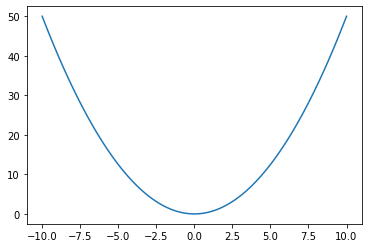

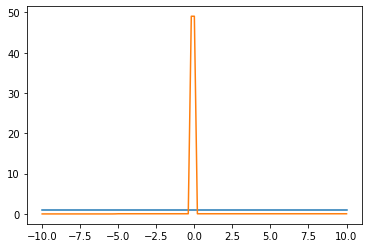

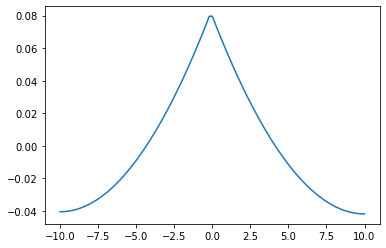

In [7]:
x = np.linspace(-10, 10, 101)
p = x
#y = np.random.random(len(x))
y = np.sin(0.5 * x)
y = 0.5 * x * x
#y = 0 * x

yy, _ = c_transform(x, y, p)
t, iopt = c_transform(p, yy, p)
plt.plot(x, t)
plt.show() 

h = 0.2
mu = np.ones_like(x)
nu = push_forward1(mu, t, h)

plt.plot(x, mu)
plt.plot(x, nu)
plt.show() 

plt.plot(x, lap_solve(nu - mu))
plt.show()